In [33]:
# Packages for assignment
import pandas as pd
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool

In [34]:
# Packages for comparative analysis
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import RepeatedKFold

In [35]:
# Read data into dataframe
song_data = pd.read_csv('song_data.csv')

In [36]:
# Check for any incomplete values
song_data.isna().sum().any()

False

In [37]:
# drop duplicate rows
song_data.drop_duplicates(inplace=True)

In [38]:
# drop outliers
for column in song_data.columns[1:]:
    Q1 = song_data[column].quantile(0.25)
    Q3 = song_data[column].quantile(0.75)
    IQR = Q3 - Q1
    song_data = song_data[song_data[column] <= (Q3+(1.5*IQR))]
    song_data = song_data[song_data[column] >= (Q1-(1.5*IQR))]
    song_data = song_data.reset_index(drop=True)

<AxesSubplot:>

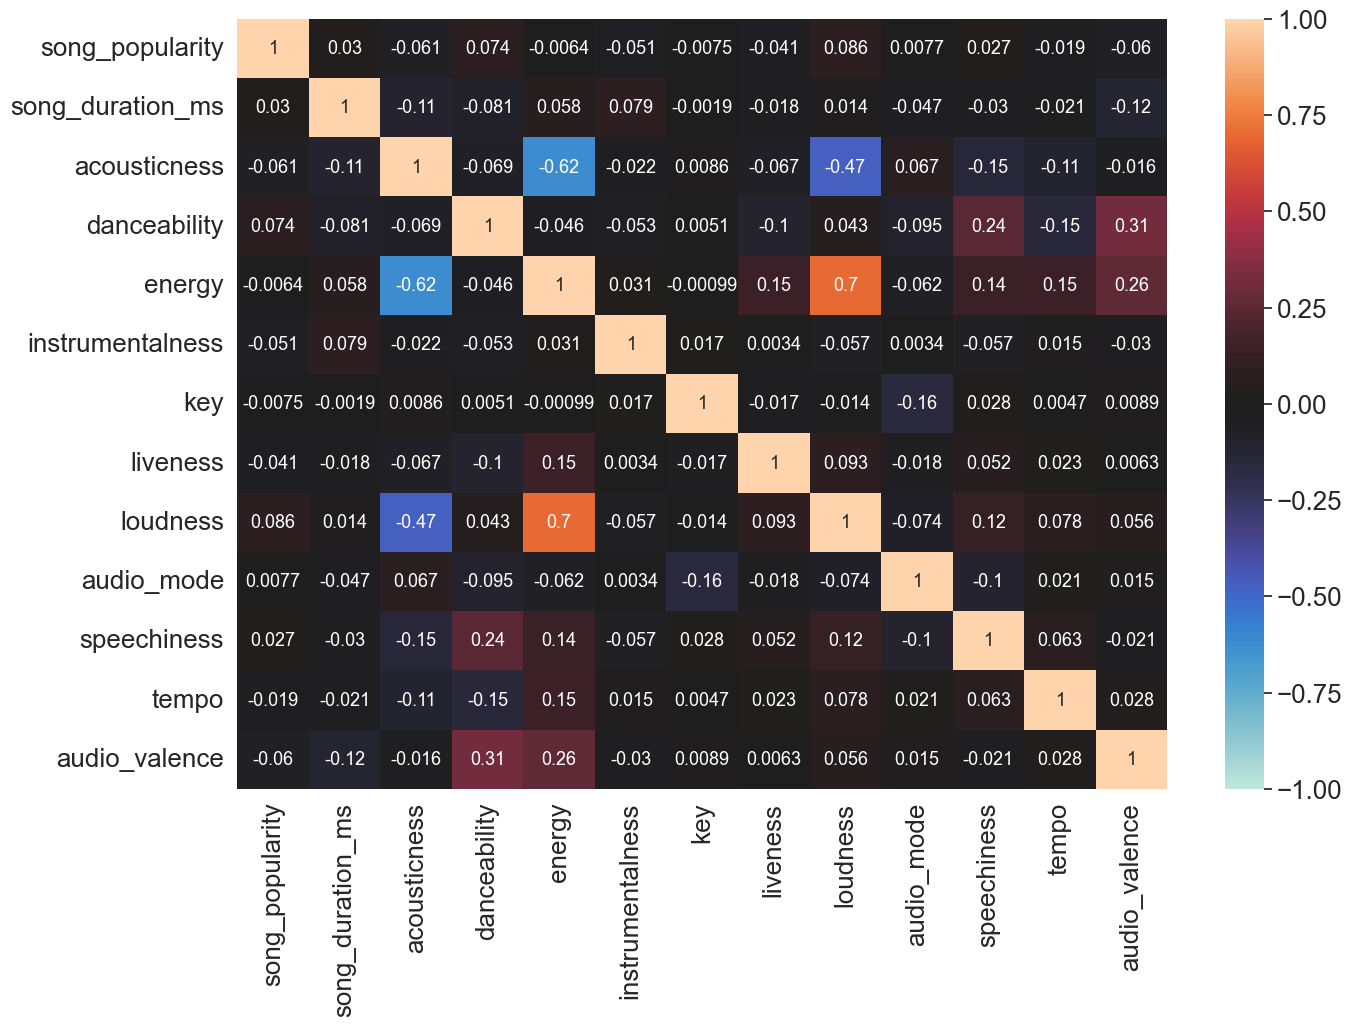

In [39]:
# Check colinearity of variables
plt.figure(figsize=[15,10])
sns.set(font_scale=1.7)
sns.heatmap(song_data.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,14]].corr(), vmin=-1, vmax=1, center=0, annot=True, annot_kws={'size':13})

In [40]:
# dummies
song_data_std = pd.get_dummies(song_data, columns=['key', 'audio_mode', 'time_signature'], drop_first=True)

# standardizing
song_data_std = pd.DataFrame(StandardScaler().fit_transform(song_data_std.iloc[:,1:]),columns = song_data_std.columns[1:])

# train/test split
traindf = song_data_std.sample(frac=0.5, random_state=0)
x_train = traindf.iloc[:, 1:]
y_train = traindf.iloc[:, 0]
testdf = song_data_std.loc[~song_data.index.isin(traindf.index)]
x_test = testdf.iloc[:, 1:]
y_test = testdf.iloc[:, 0]


In [41]:
# Base package LM for comparrison
start = time.time()

model_ols = sm.OLS(y_train, x_train).fit()

print_model_ols = model_ols.summary()
end = time.time()

print(print_model_ols)
print ("Time elapsed: \n", end - start)

                                 OLS Regression Results                                
Dep. Variable:        song_popularity   R-squared (uncentered):                   0.031
Model:                            OLS   Adj. R-squared (uncentered):              0.026
Method:                 Least Squares   F-statistic:                              6.205
Date:                Thu, 23 Mar 2023   Prob (F-statistic):                    3.54e-18
Time:                        18:35:57   Log-Likelihood:                         -5926.3
No. Observations:                4242   AIC:                                  1.190e+04
Df Residuals:                    4220   BIC:                                  1.204e+04
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

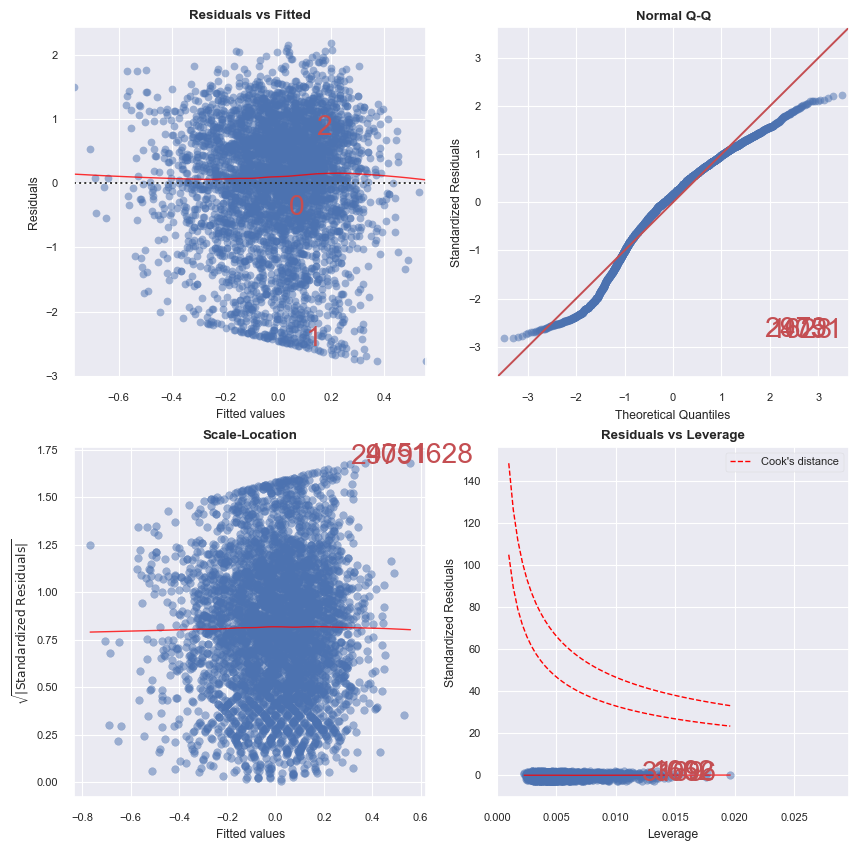

            Features  VIF Factor
4   instrumentalness        1.03
0   song_duration_ms        1.05
5           liveness        1.05
8              tempo        1.06
21      audio_mode_1        1.11
7        speechiness        1.17
12             key_3        1.23
2       danceability        1.44
9      audio_valence        1.47
19            key_10        1.50
15             key_6        1.53
17             key_8        1.54
13             key_4        1.57
20            key_11        1.64
14             key_5        1.65
11             key_2        1.66
18             key_9        1.71
16             key_7        1.76
1       acousticness        1.79
10             key_1        1.80
6           loudness        2.26
3             energy        3.37


In [42]:
# residual diagnostics
from residualplots import Linear_Reg_Diagnostic
cls = Linear_Reg_Diagnostic(model_ols)
fig, ax = cls()

In [43]:
# linear regression predictions and MSE
y_predicted_linreg = model_ols.predict(x_test)
mse_linreg = mean_squared_error(y_test, y_predicted_linreg)
r_2 = r2_score(y_test,y_predicted_linreg)
print('MSE: \n' + str(mse_linreg))
print('Test R-squared: \n' + str(r_2))



MSE: 
0.9812706156964572
Test R-squared: 
0.030035206596541464


In [44]:
# Change X and Y to numpy for matrix decomposition
#x = sm.add_constant(x_train) # adding a constant
X = x_train.to_numpy()
Y = y_train.to_numpy()
Y.reshape(-1, 1)

array([[-0.45826797],
       [-2.43766446],
       [ 0.893515  ],
       ...,
       [-0.21687815],
       [ 0.60384722],
       [-0.31343408]])

In [45]:
#Initialize transposed matrix multiplications needed
XX = X.T @ X
XY = X.T @ Y

In [14]:
# LU Decomposition

start = time.perf_counter()
# Obtain regression coefficients from an array using LU Decomposition
P, L, U = scipy.linalg.lu(XX)
LZ=P.T@X.T@Y
Z=scipy.linalg.solve_triangular(L,LZ,lower=True)
Bhat_LU = scipy.linalg.solve_triangular(U,Z,lower=False)
print(Bhat_LU)

end = time.perf_counter()
print ("Time elapsed: \n", end - start)

[ 0.02904971 -0.07502116  0.04810183 -0.13491184 -0.0395083  -0.04056905
  0.15290727 -0.00332043  0.00336882 -0.03410436 -0.00256015 -0.03125957
 -0.00296578 -0.01148645 -0.00312355  0.00674311 -0.03816858 -0.0117598
 -0.02172565 -0.00906304 -0.00667928  0.00732833]
Time elapsed: 
 0.0009538999999989528


In [15]:
# Cholesky Decomposition

start = time.perf_counter()

c,low = scipy.linalg.cho_factor(XX)
Bhat_cho = scipy.linalg.cho_solve((c,low),XY)
print(Bhat_cho)

end = time.perf_counter()
print ("Time elapsed: \n", end - start)

[ 0.02904971 -0.07502116  0.04810183 -0.13491184 -0.0395083  -0.04056905
  0.15290727 -0.00332043  0.00336882 -0.03410436 -0.00256015 -0.03125957
 -0.00296578 -0.01148645 -0.00312355  0.00674311 -0.03816858 -0.0117598
 -0.02172565 -0.00906304 -0.00667928  0.00732833]
Time elapsed: 
 0.0005112999999994372


In [16]:
# QR Decomposition

start = time.perf_counter()
# Obtain regression coefficients from an array using QR Decomposition
Q, R = np.linalg.qr(X)
RB=Q.T@Y
Bhat_QR=scipy.linalg.solve_triangular(R,RB,lower=False)
print(Bhat_QR)

end = time.perf_counter()
print ("Time elapsed: \n", end - start)

[ 0.02904971 -0.07502116  0.04810183 -0.13491184 -0.0395083  -0.04056905
  0.15290727 -0.00332043  0.00336882 -0.03410436 -0.00256015 -0.03125957
 -0.00296578 -0.01148645 -0.00312355  0.00674311 -0.03816858 -0.0117598
 -0.02172565 -0.00906304 -0.00667928  0.00732833]
Time elapsed: 
 0.012148799999998516


In [17]:
# Running data through model
LU_pred = (x_test * Bhat_LU).sum(1)
CHO_pred = (x_test* Bhat_cho).sum(1)
QR_pred = (x_test * Bhat_QR).sum(1)

In [18]:
pd.DataFrame({'y_pred': y_predicted_linreg, 'LU_pred': LU_pred, 'Cho_pred': CHO_pred, 'QR_pred': QR_pred})

,y_pred,LU_pred,Cho_pred,QR_pred
0,0.271178,0.271178,0.271178,0.271178
2,-0.109151,-0.109151,-0.109151,-0.109151
3,0.085164,0.085164,0.085164,0.085164
5,-0.056729,-0.056729,-0.056729,-0.056729
7,0.083735,0.083735,0.083735,0.083735
...,...,...,...,...
8476,-0.092075,-0.092075,-0.092075,-0.092075
8477,-0.099165,-0.099165,-0.099165,-0.099165
8478,0.031793,0.031793,0.031793,0.031793
8480,-0.331595,-0.331595,-0.331595,-0.331595


In [21]:
#%% Ridge regression

start = time.time()

# cross-validation definition
cv = RepeatedKFold(n_splits=50, n_repeats=3, random_state=1)

# ridge definition
model_ridge = RidgeCV(alphas=np.arange(0.01, 1, 0.01), cv=cv, fit_intercept=False)

# fitting
model_ridge.fit(x_train, y_train)

# print cross-validated tuning parameter choice
print('alpha: ' + str(model_ridge.alpha_))

# print ridge coefficients
print('coefficients: ' + str(model_ridge.intercept_) + ' ' + str(model_ridge.coef_[1:]))

# testing ridge predictions
score_trained = model_ridge.score(x_train, y_train)
score_tested = model_ridge.score(x_test, y_test)

# MSE
y_predicted_ridge = model_ridge.predict(x_test)
mse_ridge = mean_squared_error(y_test,y_predicted_ridge)
print('Trained R-squared: \n' + str(score_trained))
print('Test R-squared: \n' + str(score_tested))
print('MSE: \n' + str(mse_ridge))

end = time.time()
print ("Time elapsed: \n", end - start)

alpha: 0.99
coefficients: 0.0 [-0.07496197  0.04811987 -0.13473979 -0.03950955 -0.04056602  0.15278082
 -0.00332738  0.00336534 -0.03414077 -0.0025281  -0.03123314 -0.00295235
 -0.01146621 -0.00309601  0.00676    -0.03813375 -0.01173586 -0.02169815
 -0.00904144 -0.00665404  0.00732673]
Trained R-squared: 
0.031139742570305162
Test R-squared: 
0.030039567217220564
MSE: 
0.9812662042487761
Time elapsed: 
 49.95061635971069


In [20]:
#%% LASSO regression

start = time.time()

# LASSO definition
model_lasso = LassoCV(alphas=np.arange(0.001, 1, 0.001), cv=cv, n_jobs=-1, max_iter=10000, fit_intercept=False)

# fitting
model_lasso.fit(x_train, y_train)

# print cross-validated tuning parameter choice
print('alpha: ' + str(model_lasso.alpha_))

# print LASSO coefficients
print('coefficients: ' + str(model_lasso.coef_))

# testing LASSO predictions
score_trained = model_lasso.score(x_train, y_train)
score_tested = model_lasso.score(x_test, y_test)

# MSE
y_predicted_lasso = model_lasso.predict(x_test)
mse_lasso = mean_squared_error(y_test,y_predicted_lasso)

print('Trained R-squared: \n' + str(score_trained))
print('Test R-squared: \n' + str(score_tested))
print('MSE: \n' + str(mse_lasso))

end = time.time()
print ("Time elapsed: \n", end - start)

alpha: 0.007
coefficients: [ 0.02189993 -0.06112948  0.04266474 -0.10520986 -0.03391204 -0.03611507
  0.13237531 -0.          0.         -0.03252608  0.00224897 -0.01696226
  0.         -0.          0.          0.00628027 -0.02204368 -0.
 -0.00748281 -0.          0.          0.        ]
Trained R-squared: 
0.03006588129298371
Test R-squared: 
0.02905600832730948
MSE: 
0.9822612274125451
Time elapsed: 
 8.132437944412231


In [ ]:
# coefficients dropped by LASSO: speechiness, tempo, key_3, key_4, key_5, key_8, key_10, key_11, audio_mode_1

In [ ]:
# Ridge regression

start = time.time()

# cross-validation definition
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# ridge definition
model_ridge = RidgeCV(alphas=np.arange(0.0001, 1, 0.01), cv=100, fit_intercept=False)

# fitting
model_ridge.fit(x_train, y_train)

# print cross-validated tuning parameter choice
print('alpha: ' + str(model_ridge.alpha_))

# print ridge coefficients
print('coefficients: ' + str(model_ridge.intercept_) + ' ' + str(model_ridge.coef_[1:]))

# testing ridge predictions
score_trained = model_ridge.score(x_train, y_train)
score_tested = model_ridge.score(x_test, y_test)

# MSE
y_predicted_ridge = model_ridge.predict(x_test)
mse_ridge = mean_squared_error(y_test,y_predicted_ridge)
print('Trained R-squared: \n' + str(score_trained))
print('Test R-squared: \n' + str(score_tested))
print('MSE: \n' + str(mse_ridge))

end = time.time()
print ("Time elapsed: \n", end - start)

alpha: 0.9901
coefficients: 0.0 [-0.07496197  0.04811987 -0.13473977 -0.03950955 -0.04056602  0.15278081
 -0.00332738  0.00336534 -0.03414078 -0.0025281  -0.03123314 -0.00295235
 -0.01146621 -0.003096    0.00676    -0.03813375 -0.01173586 -0.02169815
 -0.00904143 -0.00665404  0.00732673]
Trained R-squared: 
0.031139742567972473
Test R-squared: 
0.03003956765555682
MSE: 
0.9812662038053307
Time elapsed: 
 32.4789035320282


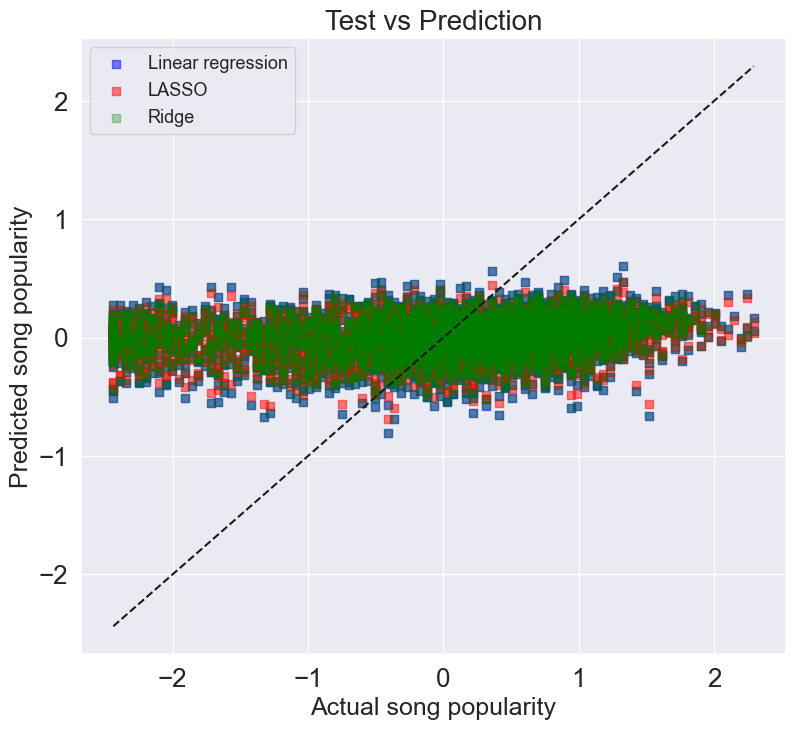

In [ ]:
# plot test vs predicted
plt.figure(num=0,figsize=[20,8])
plt.subplot(1,2,2)
plt.scatter(x=y_test,y=y_predicted_linreg, color='blue', alpha=0.5, marker=',', label = 'Linear regression')
plt.scatter(x=y_test,y=y_predicted_lasso, color='red', alpha=0.5, marker=',', label='LASSO')
plt.scatter(x=y_test,y=y_predicted_ridge, color='green', alpha=0.3, marker=',', label='Ridge')
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], 'k--')
plt.title('Test vs Prediction',fontsize=20)         
plt.xlabel('Actual song popularity',fontsize='18')                       
plt.ylabel('Predicted song popularity',fontsize='18')      
plt.legend(fontsize='13')                 
plt.show()

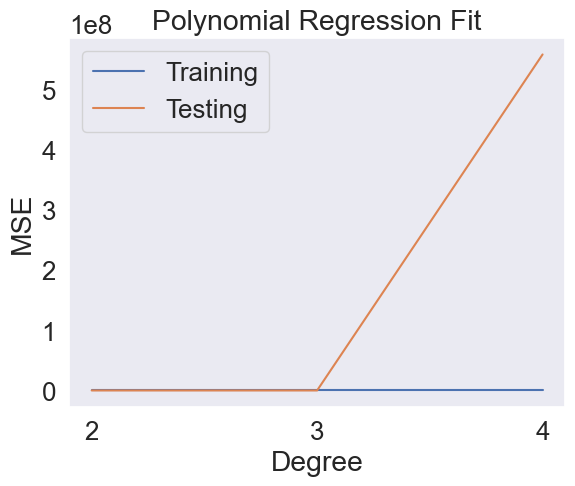

In [24]:
# Polynomial regression

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Initialize empty lists for training and testing errors
Trr=[]; Tss=[]

# Set the maximum degree of the polynomial to fit
n_degree=5

# Loop over the degrees of the polynomial to fit
for i in range(2, n_degree):
    # Create polynomial features for the training and testing data
    poly = PolynomialFeatures(degree=i)
    x_poly_train = poly.fit_transform(x_train)
    x_poly_test = poly.fit_transform(x_test)

    # Fit a linear regression model on the polynomial features
    LR = LinearRegression()
    LR.fit(x_poly_train, y_train)

    # Predict on the training data and calculate the RMSE
    pred1 = LR.predict(x_poly_train)
    Trr.append(mean_squared_error(y_train, pred1))

    # Predict on the testing data and calculate the RMSE
    pred2 = LR.predict(x_poly_test)
    Tss.append(mean_squared_error(y_test, pred2))

# Plot the MMSE of the training and testing errors for different degrees of the polynomial
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.xticks(np.arange(2, 5, 1))
plt.grid()
plt.legend()

plt.show()

In [ ]:
XX = x_poly_train.T @ x_poly_train
XY = x_poly_train.T @ y_train

In [ ]:
# Obtain regression coefficients from an array using QR Decomposition
Q, R = np.linalg.qr(XX)
RB=Q.T@XY
Bhat_QR=scipy.linalg.solve_triangular(R,RB,lower=False)
print(Bhat_QR)

[-1285.03733029 16424.81179841 -9081.43152362 ...    63.01247132
 -1177.61503524   742.93304405]


In [48]:
args = [(x_train,y_train,x_test,y_test,i,'QR') for i in range(2,5)]

In [50]:
from PolyReg import PolyReg

In [51]:
with Pool(10) as p:
    results = (p.starmap(PolyReg, args))

In [52]:
results

[(0.9038419434069782, 1.014418531135936, 0.1491391249999996),
 (0.6874204502808466, 1.734093436382944, 3.581092833),
 (0.009611873866371815, 7510487848.368822, 121.349439208)]

In [ ]:
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.xticks(np.arange(2, 4, 1))
plt.grid()
plt.legend()

plt.show()
print ("Time elapsed: \n", end - start)